# DevTool: Lattice2D
<hr><br>
Developers' tools iPython Notebook for the Lattice2D object

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use(os.path.join('ipynb', 'nb_plotsheet.mplstyle'))
#
datpath = os.path.join('ipynb', 'data')
datpath_clust_rew = os.path.join('data', 'cluster_data', 'rewired_2D')
#

Current working directory: /home/opisthofulax/Documents/PhD/projects/complex-networks/lrgsglib


In [8]:
side = 63
pflip = 0.45
T = 0.5
eigvn = 2
icc = f"gs_{eigvn}"
cell = 'randXERR'

In [11]:
l3 = Lattice2D(side, pflip=pflip, init_nw_dict=True)
l3.flip_sel_edges(l3.nwDict[cell]['G'])
l3.compute_k_eigvV(k=eigvn+1)
l3.load_eigV_on_graph(eigvn, binarize=True)
l3.make_clustersYN(f'eigV{eigvn}', val=ConditionalPartitioning(-1))

In [12]:
isdy = IsingDynamics(l3, T=T, ic=icc, runlang='C4', out_suffix='_'.join([icc, cell]))
isdy.init_ising_dynamics()
l3.export_ising_clust(exName=isdy.id_string_isingdyn, NoClust=1)
l3.export_eigV(eigvn, exName=isdy.id_string_isingdyn)
isdy.run()


In [5]:
dlttc = {}
pflip_list = [0.01, 0.05, 0.1, 0.15]

In [6]:
for pflip in pflip_list:
    kwargs_l2d = dict(side1=128, pflip=pflip)
    dlttc[pflip] = Lattice2D(**kwargs_l2d)
    dlttc[pflip].flip_random_fract_edges()
    dlttc[pflip].compute_k_eigvV(with_routine='numpy')

## Properties

### Antiferro nodes count

In [2]:
kwargs_Lattice = dict(side1=96, pflip=0.1, geo='sqr', path_data=datpath, init_nw_dict=True)

In [3]:
HexLatt = Lattice2D(**kwargs_Lattice)
HexLatt.flip_sel_edges(HexLatt.nwDict['randXERR']['G'])

In [4]:
#
count = 0
for i in HexLatt.G:
    is_antiferro_node = all([v['weight'] == -1 for k,v in HexLatt.G[i].items()])
    count += 1 if is_antiferro_node else 0 
#
fraction_antiferro_nodes = count/HexLatt.N
est_fraction_antiferro_nodes = HexLatt.pflip+HexLatt.pflip**4*(1-HexLatt.pflip)
#
print(fraction_antiferro_nodes, est_fraction_antiferro_nodes)

0.10026041666666667 0.10009000000000001


## Visualization

### Hexagonal Lattice Plot

In [26]:
kwargs_Lattice = dict(side1=32, pflip=0.2, geo='hex', path_data=datpath, init_nw_dict=True,
                      with_positions=True)

In [27]:
HexLatt = Lattice2D(**kwargs_Lattice)
HexLatt.flip_sel_edges(HexLatt.nwDict['randXERR']['G'])
data = HexLatt.get_eigV_bin_check(0, True)

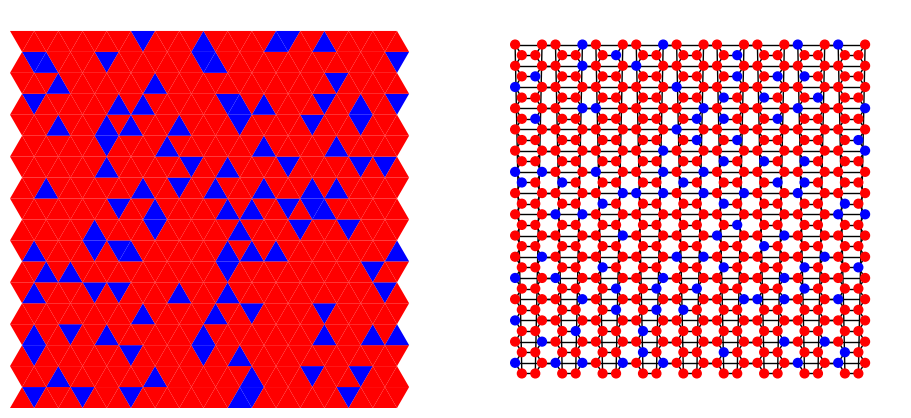

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
plot_honeycomb_grid(data, fig, ax[0], cmap='bwr')
nx.draw(HexLatt.G, ax=ax[1], pos=HexLatt.get_node_attributes('pos'), 
        node_color=data,node_size=40, node_shape="o", cmap='bwr')
fig.tight_layout()

In [30]:
HexLatt = Lattice2D(side1=16,
              pflip=0.25,  
              pbc=False, 
              geo='hexagonal', 
              init_nw_dict=True, 
              with_positions=True)
HexLatt.flip_sel_edges(HexLatt.nwDict['randZERR']['G'])

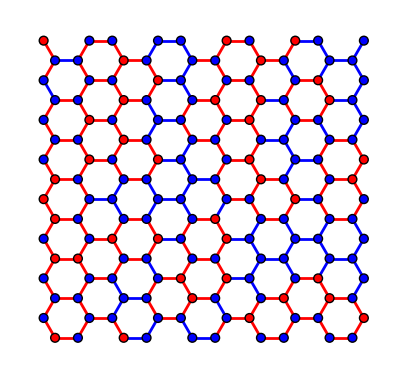

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
nx.draw(HexLatt.G, ax=ax, pos=nx.get_node_attributes(HexLatt.G, 'pos'), 
        node_size=40, 
        node_color=['red' if i in HexLatt.nwDict.rNodeFlip['G'] else 'blue' for i in HexLatt.G.nodes()],
        edgecolors='k', linewidths=1, width=2, 
        edge_color=['r' if w < 0 else 'blue' 
                    for u, v, w in list(HexLatt.G.edges(data='weight'))],
        )

### Square Lattice plot

In [47]:
def plot_eigen_images(lattice, eig_num=3, fig_side=2, kwargs_imshow=None):
    if kwargs_imshow is None:
        kwargs_imshow = dict(interpolation='none', cmap='bwr')
    fig, ax = plt.subplots(ncols=eig_num, figsize=(eig_num * fig_side, fig_side))
    for i in range(eig_num):
        ax[i].imshow(lattice.get_eigV_check(i, True, True), **kwargs_imshow)
        ax[i].axis('off')
        ax[i].annotate(
            f"{i}",
            xy=(0.9, 0.1), xycoords='axes fraction',
            ha='center', va='center',
            color='white', fontsize=12*fig_side/2,
            bbox=dict(facecolor='black', alpha=0.5, pad=2)
        )
    fig.tight_layout()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
    plt.show()

In [48]:
eig_num = 3
fig_side = 3
kwargs_Lattice = dict(side1=128, pflip=0.1, path_data=datpath)

In [49]:
l2d_tmp = Lattice2D(**kwargs_Lattice)
l2d_tmp.flip_random_fract_edges()
l2d_tmp.compute_k_eigvV(eig_num)

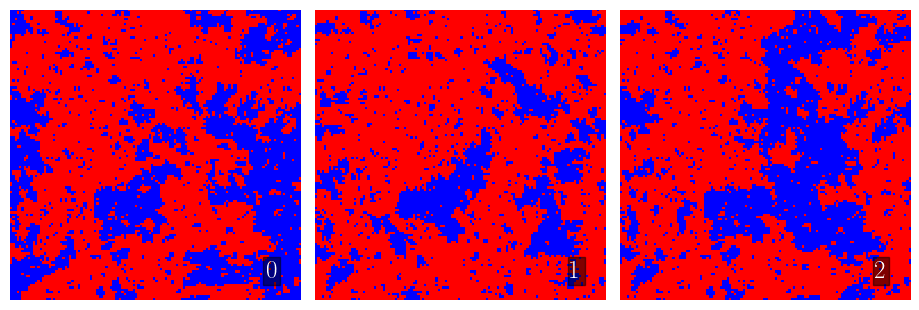

In [50]:
plot_eigen_images(l2d_tmp, eig_num, fig_side)

### Triangular Lattice plot

In [2]:
side = 32
geo = 'tri'
pflip = 1
with_positions = True
#
kwargs_TriL2D = dict(side1=side, geo=geo, pflip=pflip, 
                     with_positions=with_positions)

In [3]:
TriL2D = Lattice2D(**kwargs_TriL2D)
TriL2D.flip_random_fract_edges()
TriL2D.compute_k_eigvV(with_routine='numpy')

In [ ]:
graph = TriL2D.G
pos = TriL2D.get_node_attributes('pos')
vals = TriL2D.get_eigV_bin_check(0)
points = np.array(list(pos.values()))
x, y = points.T

/tmp/ipykernel_55364/2446173710.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(cmap)


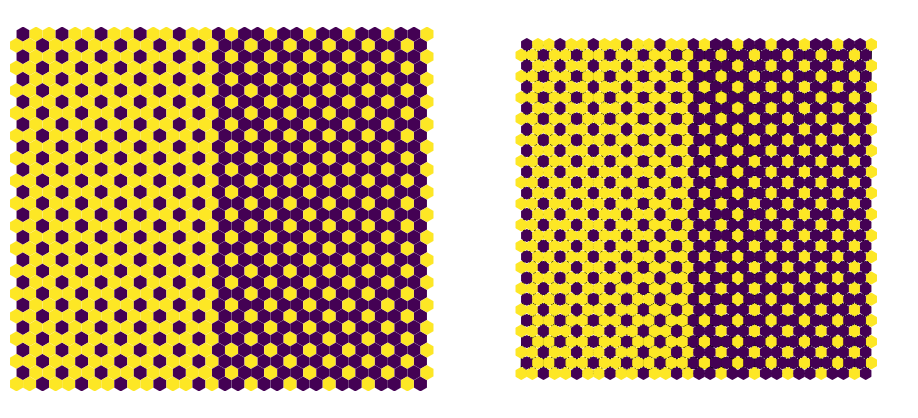

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
#
plot_hex_tiling_from_nodes(x, y, vals, ax=ax[0])
ax[0].axis('off')
#
nx.draw(graph, ax=ax[1], pos=pos, node_color=vals,
        node_size=70, node_shape="h")
#
fig.tight_layout()

## Work in progress

In [ ]:
T=10

In [ ]:
TriLatt = Lattice2D(32, pflip=pflip, geo='tri')
TriLatt.flip_random_fract_edges()
TriLatt.compute_k_eigvV(with_routine='numpy')

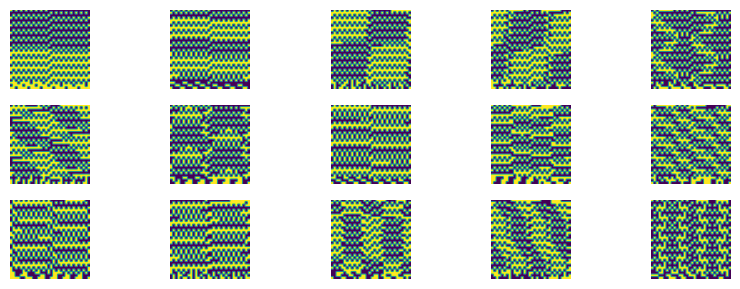

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 3.5))
count = 0
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(TriLatt.get_eigV_bin_check(count).reshape(*TriLatt.syshape), origin='lower')
        ax[i, j].axis('off')
        count += 2

In [ ]:
isdy = IsingDynamics(TriLatt, T=T, ic='ground_state_0', runlang='C1', rndStr=True, thrmSTEP=100)
isdy.init_ising_dynamics(exName=isdy.id_string_isingdyn)
isdy.run(verbose=False)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    TriLatt.remove_edgl_file()

AttributeError: 'IsingDynamics' object has no attribute 'export_ising_clust'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(isdy.s.reshape(*TriLatt.syshape), origin='lower')
ax.axis('off')

In [ ]:
isdy2 = IsingDynamics(TriLatt, T=0, ic='custom', runlang='C1', rndStr=True)
isdy2.init_ising_dynamics(custom=isdy.s)
TriLatt.export_edgel_bin(exName=isdy2.id_string_isingdyn)
isdy2.export_ising_clust()
isdy2.run(verbose=False, thrmSTEP=100)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(isdy2.s.reshape(*TriLatt.syshape), origin='lower')
ax.axis('off')

In [ ]:
def spin_overlap(S1, S2):
     # Ensure both matrices have the same shape
     assert S1.shape == S2.shape, "Matrices must have the same shape!"

     # Direct overlap
     direct_overlap = np.sum(S1 * S2) / S1.size

     # Flipped overlap (inverted spins)
     flipped_overlap = np.sum(S1 * (-S2)) / S1.size

     # Return the maximum overlap, accounting for possible inversion
     return max(direct_overlap, flipped_overlap)

def matrix_projection(M, basis):
     projections = []

     # Iterate over each basis matrix
     for B_i in basis:
         # Compute the inner product between M and B_i
         inner_product = np.sum(M * B_i)

         # Compute the Frobenius norm of the basis matrix B_i
         norm_Bi = np.linalg.norm(B_i)

         # Compute the projection (normalized inner product)
         projection_i = inner_product / norm_Bi

         # Append the projection to the result list
         projections.append(projection_i)

     return projections
def reconstruct_from_projections(projections, basis):
     # Initialize the reconstructed matrix as zero
     reconstructed_matrix = np.zeros_like(basis[0])

     # Multiply each projection by its corresponding basis matrix and sum
     for i, B_i in enumerate(basis):
         reconstructed_matrix += projections[i] * B_i

     return reconstructed_matrix
def elements_within_eta_numpy(array, eta):
    """
    Returns elements in the array that are within eta from the minimum value.
    
    Parameters:
    - array (array-like): Input array of numerical values.
    - eta (float): Threshold value.
    
    Returns:
    - filtered_elements (np.ndarray): Elements within eta from the minimum.
    """
    array = np.array(array)  # Ensure input is a NumPy array
    min_val = np.min(array)
    displacement = array - min_val
    mask = displacement <= eta
    filtered_elements = array[mask]
    return filtered_elements

In [ ]:
overlap = np.array([spin_overlap(isdy.s.reshape(*HexLatt.syshape),HexLatt.get_eigV_bin_check(i).reshape(*HexLatt.syshape)) for i in range(HexLatt.N)])
sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*HexLatt.syshape)
basis = np.array([HexLatt.eigV[i].reshape(*HexLatt.syshape) for i in sorted_args[:500]])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
overlap[sorted_args[:3]]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-HexLatt.get_eigV_bin_check(sorted_args[i]).reshape(*HexLatt.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*HexLatt.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

In [ ]:
spin_overlap(isdy.s.reshape(*HexLatt.syshape), np.sign(reconstruct_from_projections(projections, basis)))

In [ ]:
test_ene = [HexLatt.get_rbim_energy_eigV(_) for _ in range(HexLatt.N)]

In [ ]:
plt.plot(test_ene)

In [ ]:
ls = Lattice2D(32, pflip=pflip, geo='sqr')
ls.flip_random_fract_edges()
ls.compute_k_eigvV(MODE_dynspec='numpy')

In [ ]:
test_enes = [ls.get_rbim_energy_eigV(_) for _ in range(ls.N)]
plt.plot(test_enes)

In [ ]:
ls = Lattice2D(32, pflip=0.01, prew=0.5, geo='sqr')
ls.flip_random_fract_edges()
ls.compute_k_eigvV(MODE_dynspec='numpy')

In [ ]:
test_enes = [ls.get_rbim_energy_eigV(_) for _ in range(ls.N)]


In [ ]:
plt.plot(test_enes)

## Phase transition

### Rewired small world network (data from cluster)

In [ ]:
LList = [32, 64, 96]
prew = 0.05
na = 10000
pL = np.linspace(0, 0.3, 100)
dat = {}

In [ ]:
for L in LList:
    dat[L] = []
    l2 = Lattice2D(L, prew=prew, dataOut=datpath_clust_rew)
    for p in pL:
        dat[L].append(np.loadtxt(
            os.path.join(l2.phtrapath, 'ordParam'+\
                         '_'.join(["", f"p={p:.3g}", "rand", f"na={na}", 
                                   f"prew={prew:.3g}.txt"]))))

In [ ]:
for L in LList:
    plt.plot(pL, np.array(dat[L])[:, 4], label=f"{L*L}")
plt.xlabel(r'$p$')
plt.legend(loc='lower left', fontsize=30)
plt.title(r"Lattice 2D -- $p_{\rm rew} = 0.05$")
inset_axes(plt.gca(), width="40%", height="40%")
for L in LList:
    plt.plot(pL, np.array(dat[L])[:, 5]*L)

## Basic Visualization

### Small world Lattice 2D

In [ ]:
side = 16
prew = 0.05
pflip = 0.1
#
l_sw = Lattice2D(side, prew=prew, with_positions=True)
nx.draw(l_sw.G, pos=l_sw.get_node_attributes(), node_size=10)

# Trash

In [ ]:
pflip = 0.25
side1 = 32

In [ ]:
HexLatt = Lattice2D(side1, pflip=pflip)
HexLatt.flip_sel_edges(HexLatt.fleset['G'])
HexLatt.compute_k_eigvV(MODE_dynspec="numpy")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

arr = HexLatt.eigV[0].reshape(*HexLatt.syshape)
compound_log_array = np.where(arr > 0, -np.log(arr), 
                              np.where(arr < 0, np.log(-arr), arr))

im = ax1.imshow(arr)
ax1.set_title(r"$|\lambda_0\rangle$")
plt.colorbar(im, ax=ax1)
im = ax2.imshow(compound_log_array)
ax2.set_title(r"$-\log(|\lambda_0^+\rangle)+\log(-|\lambda_0^-\rangle)$")
plt.colorbar(im, ax=ax2)
im = ax3.imshow(HexLatt.bin_eigV().reshape(*HexLatt.syshape))
ax3.set_title(r"$\mathrm{sign}(|\lambda_0\rangle)$")
plt.colorbar(im, ax=ax3)
plt.suptitle(f"Eigenvector 0 - p={pflip}")

In [ ]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(HexLatt.eigv[:100])))
ff = [HexLatt.compute_rbim_energy_eigV(_) for _ in range(100)]

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot each horizontal line with a different color
for value, value2, color in zip(HexLatt.eigv[:100], ff, colors):
    ax1.axhline(value, color=color)
    ax2.axhline(value2, color=color)
ax1.set_yscale('log')
plt.show()

In [ ]:
eigvlist = []
for i in range(100):
    HexLatt = Lattice2D(side1, pflip=0.5, seed=i)
    HexLatt.flip_sel_edges(HexLatt.fleset['G'])
    HexLatt.compute_k_eigvV()
    eigV = HexLatt.bin_eigV().reshape(*HexLatt.syshape)
    eigvlist.append(eigV)

In [ ]:
plt.imshow(eigvlist[40])

In [ ]:
from itertools import combinations
def calculate_overlap(arr1, arr2):
    return np.sum(arr1 == arr2)
overlaps = []
for (arr1, arr2) in combinations(eigvlist, 2):
    overlaps.append(calculate_overlap(arr1, arr2))

In [ ]:
plt.hist(overlaps, bins=30, edgecolor='black')

In [ ]:
test = pk.load(open('data/l2d_squared/lrgsg/N=4096/pCluster_p=0.103_randZERR_na=500_test01.pkl', 'rb'))

In [ ]:
k,v  = unzip_dict_items(test)
arr = np.repeat(k, v)
x, pdf = powerlaw.pdf(arr, xmin=1)

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(7, 3.5))
#
ax.loglog(x[1:], pdf, 'o')
ax.loglog(x[1:], x[1:]**(-2.05))
#
ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$P(S)$")
#
fig.tight_layout()

In [ ]:
HexLatt = Lattice2D(32, geo='hexagonal', with_positions=True, pbc=False)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect('equal')
nx.draw(HexLatt.G, ax=ax, pos=HexLatt.get_node_pos(), node_size=10, with_labels=False)

In [ ]:
def eigV_for_lattice(side, **kwargs):
    l = Lattice2D(side, **kwargs)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='scipy')
    return flip_to_positive_majority(l.eigV[0])
def create_symmetric_log_bins(min_val, max_val, num_bins, incMagn = 4):
    """Creates symmetric logarithmic bins."""
    bins_positive = np.logspace(np.log10(min_val)-incMagn, np.log10(max_val)+incMagn, num_bins//2)
    bins_negative = -np.flip(bins_positive)
    return np.concatenate((bins_negative, [0], bins_positive))

def bin_eigenvalues(eig_values, bins):
    """Bins eigenvalues and counts occurrences in each bin."""
    indices = np.digitize(eig_values, bins, right=True)
    return Counter(indices)

In [ ]:
# Get initial eigenvalues to define bins
initial_eig = eigV_for_lattice(side, pflip=pflip, geo=geo)
bins = create_symmetric_log_bins(np.min(np.abs(initial_eig)), np.max(np.abs(initial_eig)), bins_count)
bin_counter = Counter()

if not os.path.exists(fname):
    nAvgDone = 0
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if fnameExists:
        nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
    nAvgNeed = nAvg - nAvgDone
    fnameOld = fnameExists[0]
    for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
        batch_size = min(nAvgNeed - current_period * period, period)
        eig_values = np.concatenate([eigV_for_lattice(side, pflip=pflip, geo=geo) for _ in range(batch_size)])
        bin_counter.update(bin_eigenvalues(eig_values, bins))
        fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
        try:
            os.rename(fnameOld, fnameNew)
        except FileNotFoundError:
            pass
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)
        fnameOld = f"{workDir}{fnameBase}_{nAvgDone + current_period * period}.pkl" if current_period > 0 else ""

    # At the end, save the final state if needed
    if nAvgNeed % period:
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)


In [ ]:
k,v = zip(*pk.load(open(f"{workDir}{fnameBase}_{nAvg}.pkl", "rb")).items())
binsv = bins[np.array(k)-1]
zero_index = np.where(binsv > 0)[0][0]
negative_values = v[:zero_index]
positive_values = v[zero_index:]
plt.plot(binsv, v, 'o')
# plt.axhline(np.max(positive_values))
# plt.axhline(np.max(negative_values))

plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')


In [ ]:
negative_values, zero_index, np.where(binsv < 0), binsv

In [ ]:
HexLatt = Lattice2D(128, pflip=0.01)
HexLatt.flip_random_fract_edges()
HexLatt.compute_k_eigvV()
outp, outm = symlog_binning(flip_to_positive_majority(HexLatt.eigV[0]))

In [ ]:
plt.plot(outp[0], outp[1], 'o-')
plt.plot(outm[0], outm[1], 'o-')

In [ ]:
nAvg = 1000
pflip = 0.05
side = 16
geo = 'squared'

period = 20
freq = period**(-1)
workDir = "test/"
fnameBase = "tmp"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"

if not os.path.exists(fname):
    nAvgDone = 0
    flist = os.listdir(workDir)
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if len(fnameExists) > 1:
        print(f"Multiple files found for {fnameBase}")
        print(fnameExists)
        exit()
    else:
        if fnameExists:
            nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
            print(nAvgDone)
    nAvgNeed = nAvg - nAvgDone
    #
    lEigV = []
    print(fnameExists)
    fnameOld = fnameExists[0] if nAvgDone else ""
    if nAvgNeed < period:
        lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                 for i in range(nAvgNeed)]
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        os.rename(fnameOld, fnameNew)
        with open(fname, "ab") as f:
            pk.dump(lEigV, f)
    else:
        for _ in range(period):
            lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                    for i in range(nAvgNeed//period)]
            fnameNew = f"{workDir}{fnameBase}_{nAvgDone+(_+1)*nAvgNeed//period}.pkl"
            try:
                os.rename(fnameOld, fnameNew)
            except FileNotFoundError:
                pass
            with open(fnameNew, "ab") as f:
                pk.dump(lEigV, f)
            fnameOld = f"{workDir}{fnameBase}_{nAvgDone+(_+1)*nAvgNeed//period}.pkl"
        if nAvgNeed%period:
            lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                    for i in range(nAvgNeed%period)]
            fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
            with open(fnameNew, "ab") as f:
                pk.dump(lEigV, f)

# for i in range(nAvg):
#     l = Lattice2D(side, pflip=pflip)
#     l.flip_random_fract_edges()
#     l.compute_k_eigvV()
#     lEigV.append(l.eigV[0])
#     with open(fname, "ab") as f:
#         pk.dump(, f)
#         f.flush()

In [ ]:
all_data = []
with open(fname, "rb") as f:
    # Loop until the end of the file
    while True:
        try:
            # Unpickle the next chunk of data and append it to the list
            data_chunk = pk.load(f)
            all_data.extend(data_chunk)
        except EOFError:
            # Reached the end of the file
            break

In [ ]:
all_data

In [ ]:
data.shape

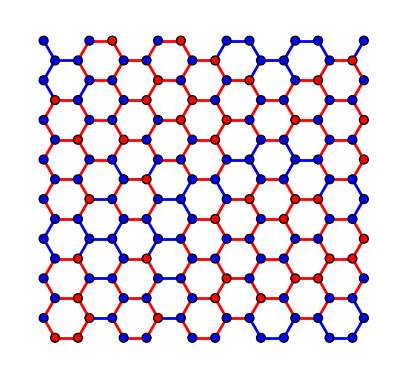